In [ ]:
#Mounting with drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Some Necessary Imports
import pandas as pd
import numpy as np
import sklearn
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import spacy

In [ ]:
#Data Loading
train = pd.read_csv('/content/drive/MyDrive/ANLE_Report_Data/propaganda_train.tsv', sep='\t')
val   = pd.read_csv('/content/drive/MyDrive/ANLE_Report_Data/propaganda_val.tsv', sep='\t')
print(train.shape, val.shape)
print("Columns in train:", train.columns.tolist())
train.head()

(2414, 2) (580, 2)
Columns in train: ['label', 'tagged_in_context']


,label,tagged_in_context
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed."
1,not_propaganda,This declassification effort <BOS> won’t make ...
2,flag_waving,The Obama administration misled the <BOS> Amer...
3,not_propaganda,“It looks like we’re capturing the demise of t...
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>"


In [ ]:
# Import libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Paths to your dataset files (update these paths as needed)
TRAIN_PATH = '/content/drive/MyDrive/ANLE_Report_Data/propaganda_train.tsv'
VAL_PATH   = '/content/drive/MyDrive/ANLE_Report_Data/propaganda_val.tsv'

In [ ]:
#Loading the data
train = pd.read_csv(TRAIN_PATH, sep='\t')
val   = pd.read_csv(VAL_PATH, sep='\t')

print("Train shape:", train.shape)
print("Val shape:", val.shape)
print("Columns in train:", train.columns.tolist())
train.head()


Train shape: (2414, 2)
Val shape: (580, 2)
Columns in train: ['label', 'tagged_in_context']


,label,tagged_in_context
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed."
1,not_propaganda,This declassification effort <BOS> won’t make ...
2,flag_waving,The Obama administration misled the <BOS> Amer...
3,not_propaganda,“It looks like we’re capturing the demise of t...
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>"


In [ ]:
# making sure the data has loaded
print(train.columns.tolist())
train.head()

['label', 'tagged_in_context']


,label,tagged_in_context
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed."
1,not_propaganda,This declassification effort <BOS> won’t make ...
2,flag_waving,The Obama administration misled the <BOS> Amer...
3,not_propaganda,“It looks like we’re capturing the demise of t...
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>"


In [ ]:
# After loading train and val removing the BOS/EOS markers or leaving them as possible features
for df in (train, val):
    df['text'] = df['tagged_in_context'].str.replace(r'<BOS>|<EOS>', '', regex=True)


In [ ]:
#Extracting just the span tag
import re

# Extract just the span for analysis:
def extract_span(tagged):
    # one BOS/EOS pair is assumed exactly
    return re.search(r'<BOS>(.*?)<EOS>', tagged).group(1).strip()
#Applicatiob
train['span_only'] = train['tagged_in_context'].apply(extract_span)
val['span_only']   = val['tagged_in_context'].apply(extract_span)


In [ ]:
# First tasks baseline and error analysis

import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# build mappings while keeping original label
train = train.rename(columns={'label':'true_technique'})
val   = val.rename(columns={'label':'true_technique'})
# Create an exclusive pattern of individuals followed by a directive propoganda and map them by IDS
techniques = sorted(train['true_technique'].unique().tolist())
label2id   = {label: idx for idx, label in enumerate(techniques)}
id2label   = {idx: label for label, idx in label2id.items()}
# Mapping the class labels in text form into numeric labels.Font setting is also applied by generating the most numerous elements to come top. All mapping is done with __dictType__ reference
train['label'] = train['true_technique'].map(label2id)
val['label']   = val['true_technique'].map(label2id)

# 2. extracting the span text again
def extract_span(tagged):
    m = re.search(r'<BOS>(.*?)<EOS>', tagged)
    return m.group(1).strip() if m else tagged

for df in (train, val):
    df['span_only'] = df['tagged_in_context'].apply(extract_span)

# Vectoriziong and training only the span detection base line.
vect   = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features=5000)
X_tr   = vect.fit_transform(train['span_only'])
X_val_ = vect.transform(val['span_only'])
y_tr   = train['label']
y_val  = val['label']
#Logistic regression clf
clf = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')
clf.fit(X_tr, y_tr)
y_pred = clf.predict(X_val_)

# 4 print the entire performance of this
print("=== Span-Only TF-IDF + LR Baseline ===")
print(classification_report(y_val, y_pred, target_names=techniques))

# the top confusions listed on a confusion matrix
cm = confusion_matrix(y_val, y_pred, labels=list(id2label.keys()))
print("Confusion matrix (rows=true, cols=pred):")
print(cm, "\n")
#printing them out
print("Top confusions per true class:")
for idx, row in enumerate(cm):
    r = row.copy()
    r[idx] = 0
    mc = np.argmax(r)
    print(f"  {id2label[idx]}  →  {id2label[mc]}  ({r[mc]} errors)")

# Misclassification is printing as examples
mis = val.copy()
mis['pred_label']     = y_pred
mis = mis[mis['pred_label'] != mis['label']]
mis['pred_technique'] = mis['pred_label'].map(id2label)
#span print
print("\nSample misclassified spans:")
print(mis[['tagged_in_context','span_only','true_technique','pred_technique']].head(10))


=== Span-Only TF-IDF + LR Baseline ===
                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.41      0.21      0.28        43
causal_oversimplification       0.29      0.13      0.18        31
                    doubt       0.46      0.32      0.38        38
exaggeration,minimisation       0.23      0.21      0.22        28
              flag_waving       0.62      0.54      0.58        39
          loaded_language       0.36      0.11      0.17        37
    name_calling,labeling       0.29      0.16      0.21        31
           not_propaganda       0.63      0.86      0.73       301
               repetition       0.47      0.22      0.30        32

                 accuracy                           0.57       580
                macro avg       0.42      0.31      0.34       580
             weighted avg       0.52      0.57      0.52       580

Confusion matrix (rows=true, cols=pred):
[[  9   0   2   6   0   0   2  23   1]
 [  4  

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model       import LogisticRegression
from sklearn.metrics           import f1_score
from sklearn.model_selection   import ParameterGrid
#the training and validation data being set  up
X_tr, y_tr = train['span_only'], train['label']
X_va, y_va =   val['span_only'],   val['label']
# the search grid hyperparams are being defined
param_grid = {'ngram_range': [(1,1), (1,2), (1,3)], 'C': [0.01, 0.1, 1, 10]}
# to store each result of model configuration
records = []
#iterating through all
for params in ParameterGrid(param_grid):
    vect = TfidfVectorizer(stop_words='english', ngram_range=params['ngram_range'], max_features=5000 )
    Xtr_vec  = vect.fit_transform(X_tr)
    Xva_vec  = vect.transform   (X_va)
    clf = LogisticRegression(solver='liblinear', C=params['C'], class_weight='balanced', max_iter=1000).fit(Xtr_vec, y_tr)
    y_pred   = clf.predict(Xva_vec)
    f1       = f1_score(y_va, y_pred, average='macro')
    records.append({ 'ngram_range': f"{params['ngram_range']}", 'C': params['C'],'macro_f1': f1
    })

df_lr = pd.DataFrame(records)


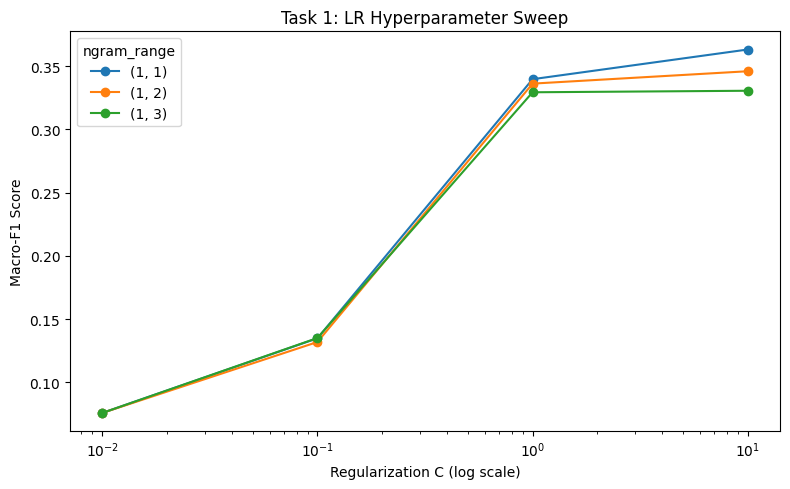

In [ ]:
import matplotlib.pyplot as plt
#Plotting the hyperparameter sweep
plt.figure(figsize=(8, 5))
for ngram, group in df_lr.groupby('ngram_range'):
    plt.plot(group['C'], group['macro_f1'], marker='o', label=ngram)
plt.xscale('log')
plt.xlabel('Regularization C (log scale)')
plt.ylabel('Macro-F1 Score')
plt.title('Task 1: LR Hyperparameter Sweep')
plt.legend(title='ngram_range')
plt.tight_layout()
plt.show()


In [ ]:
# Fine-Tuned Bert model for task 1

import re
import torch
from torch.utils.data import Dataset
from transformers import (
    BertTokenizerFast,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Label mappings defined
techniques = ['appeal_to_fear_prejudice','causal_oversimplification', 'doubt','exaggeration,minimisation','flag_waving','loaded_language','name_calling,labeling','not_propaganda','repetition']
label2id = {label: idx for idx, label in enumerate(techniques)}
id2label = {idx: label for label, idx in label2id.items()}

# Extract on;y the span ones
def extract_span(txt):
    m = re.search(r'<BOS>(.*?)<EOS>', txt)
    return m.group(1).strip() if m else txt

train['span_only'] = train['tagged_in_context'].apply(extract_span)
val['span_only']   = val['tagged_in_context'].apply(extract_span)

# 3. Tokenizer and model
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(techniques),
    label2id=label2id,
    id2label=id2label
)

# 4. Dataset wrapper
class PropagandaDataset(Dataset):
    def __init__(self, df):
        texts = df['span_only'] + " [SEP] " + df['tagged_in_context'].str.replace(r'<BOS>|<EOS>', '', regex=True)
        self.encodings = tokenizer(
            texts.tolist(),
            truncation=True,
            padding='max_length',
            max_length=128
        )
        self.labels = df['label'].tolist()
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = PropagandaDataset(train)
eval_dataset  = PropagandaDataset(val)

# 5. Metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds  = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1_macro': f1}

# 6. Minimal TrainingArguments
training_args = TrainingArguments(
    output_dir='./bert_task1',
    logging_dir='./logs',
    logging_steps=100,
    save_steps=500,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    report_to=["none"]
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics
)
trainer.train()

metrics = trainer.evaluate(eval_dataset=eval_dataset)
print("Validation metrics:", metrics)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,1.619000
200,1.361700
300,1.102600
400,0.922400


Validation metrics: {'eval_loss': 1.0557721853256226, 'eval_accuracy': 0.656896551724138, 'eval_precision': 0.4449605220917896, 'eval_recall': 0.428134402215916, 'eval_f1_macro': 0.4051995397734186, 'eval_runtime': 240.2076, 'eval_samples_per_second': 2.415, 'eval_steps_per_second': 0.079, 'epoch': 3.0}


In [ ]:
# Bert with error analysis for task 1

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# obtain predictions from the model on the validation set
outputs = trainer.predict(eval_dataset)
preds = np.argmax(outputs.predictions, axis=-1)
true_labels = outputs.label_ids

# 2. Confusion matrix
cm = confusion_matrix(true_labels, preds, labels=list(id2label.keys()))
print("Confusion matrix (rows=true, cols=pred):")
print(cm, "\n")

# 3. Top confusions per true class
print("Top confusions per true class:")
for idx, row in enumerate(cm):
    tmp = row.copy()
    tmp[idx] = 0
    most_conf = np.argmax(tmp)
    print(f"  {id2label[idx]} → {id2label[most_conf]} ({tmp[most_conf]} errors)")

# 4. Classification report
print("\nClassification Report for BERT on Validation Set:")
print(classification_report(true_labels, preds, target_names=list(id2label.values())))

# 5. Show sample misclassified spans
mis = val.copy()
mis['pred_label'] = preds
mis = mis[mis['pred_label'] != mis['label']]
mis['true_technique'] = mis['label'].map(id2label)
mis['pred_technique'] = mis['pred_label'].map(id2label)

print("\nSample misclassifications:")
print(mis[['tagged_in_context','span_only','true_technique','pred_technique']].head(10))


Confusion matrix (rows=true, cols=pred):
[[ 17  11   1   2   1   1   1   7   2]
 [  2  22   2   1   0   1   0   3   0]
 [  0  18   3   0   2   2   0  12   1]
 [  2   6   0   6   1   3   5   5   0]
 [  6   8   1   2  17   1   2   1   1]
 [  2   1   0   0   1  19  10   3   1]
 [  0   0   0   3   0   7  16   4   1]
 [  3   5   0   3   2   2   4 279   3]
 [  2   1   0   1   4  11   5   6   2]] 

Top confusions per true class:
  appeal_to_fear_prejudice → causal_oversimplification (11 errors)
  causal_oversimplification → not_propaganda (3 errors)
  doubt → causal_oversimplification (18 errors)
  exaggeration,minimisation → causal_oversimplification (6 errors)
  flag_waving → causal_oversimplification (8 errors)
  loaded_language → name_calling,labeling (10 errors)
  name_calling,labeling → loaded_language (7 errors)
  not_propaganda → causal_oversimplification (5 errors)
  repetition → loaded_language (11 errors)

Classification Report for BERT on Validation Set:
                          

                                      Model  Accuracy  Macro-F1
0  TF-IDF + Logistic Regression (span-only)    0.5700    0.3400
1                     BERT (span + context)    0.6569    0.4052


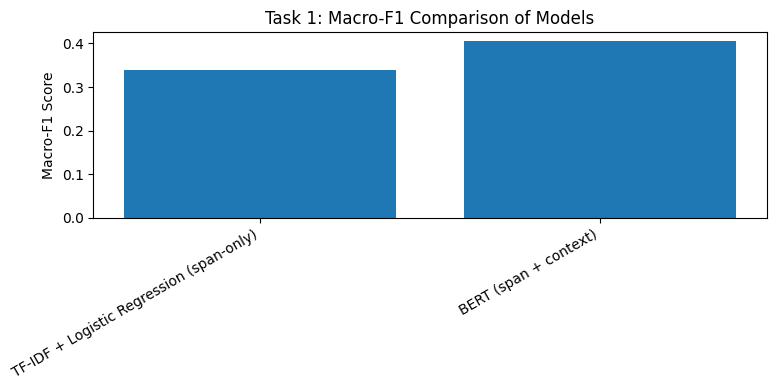

In [ ]:
# histogram and table of the model results
import pandas as pd
import matplotlib.pyplot as plt

# Create comparison table
results = pd.DataFrame({
    'Model': ['TF-IDF + Logistic Regression (span-only)','BERT (span + context)'],'Accuracy': [0.57, 0.6569], 'Macro-F1': [0.34, 0.4052]})

# Display the table
print(results)

# macro-f1 bar chart
plt.figure(figsize=(8, 4))
plt.bar(results['Model'], results['Macro-F1'])
plt.ylabel('Macro-F1 Score')
plt.title('Task 1: Macro-F1 Comparison of Models')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
#Baseline on all of the contexts
# (We’ll strip BOS/EOS but keep the rest as our “sentence context”)
train['context_only'] = train['tagged_in_context'].str.replace(r'<BOS>|<EOS>', '', regex=True)
val['context_only']   = val['tagged_in_context'].str.replace(r'<BOS>|<EOS>', '', regex=True)

vect_ctx = TfidfVectorizer( stop_words='english', ngram_range=(1,2), max_features=10000 )
X_train_ctx = vect_ctx.fit_transform(train['context_only'])
X_val_ctx   = vect_ctx.transform(val['context_only'])

clf_ctx = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')
clf_ctx.fit(X_train_ctx, train['label'])

y_pred_ctx = clf_ctx.predict(X_val_ctx)
print("=== Full Context Baseline ===")
print(classification_report(val['label'], y_pred_ctx, target_names=techniques))


=== Full Context Baseline ===
                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.34      0.23      0.28        43
causal_oversimplification       0.15      0.06      0.09        31
                    doubt       0.37      0.18      0.25        38
exaggeration,minimisation       0.24      0.18      0.20        28
              flag_waving       0.54      0.49      0.51        39
          loaded_language       0.09      0.03      0.04        37
    name_calling,labeling       0.15      0.06      0.09        31
           not_propaganda       0.63      0.87      0.73       301
               repetition       0.35      0.22      0.27        32

                 accuracy                           0.54       580
                macro avg       0.32      0.26      0.27       580
             weighted avg       0.47      0.54      0.49       580



In [ ]:
# TASK 2 loading necessary data in order to rerun tasks faster
train = train.rename(columns={'label':'true_technique'})
val   = val.rename(columns={'label':'true_technique'})

techniques = sorted(train['true_technique'].unique().tolist())
label2id   = {t:i for i,t in enumerate(techniques)}
train['label'] = train['true_technique'].map(label2id)
val['label']   = val['true_technique'].map(label2id)

from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Preprocessing for Task 2 here I convert tagged_in_context markers to BIO token tags

import re
from transformers import BertTokenizerFast

# Initialize tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

def tokenize_and_bio(df):
    texts = []
    all_labels = []
    for tagged, tech in zip(df['tagged_in_context'], df['true_technique']):
        # Remove markers and record span offsets
        m = re.search(r'<BOS>(.*?)<EOS>', tagged)
        span_text = m.group(1).strip()
        cleaned = tagged.replace('<BOS>', '').replace('<EOS>', '')
        # Find span positions
        start_char = cleaned.find(span_text)
        end_char = start_char + len(span_text)
        # Tokenize with offsets present
        enc = tokenizer(cleaned, return_offsets_mapping=True, truncation=True, padding='max_length', max_length=128)
        labels = []
        for (offset_start, offset_end) in enc.offset_mapping:
            if offset_start == offset_end == 0:
                # Special tokens
                labels.append('O')
            elif offset_start >= start_char and offset_end <= end_char:
                # Inside span
                if offset_start == start_char:
                    labels.append(f'B-{tech}')
                else:
                    labels.append(f'I-{tech}')
            else:
                labels.append('O')

        texts.append(enc)
        all_labels.append(labels)

    # Build dict of lists for model input
    input_ids = [item['input_ids'] for item in texts]
    attention_mask = [item['attention_mask'] for item in texts]

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': all_labels
    }

# Example use
bio_train = tokenize_and_bio(train)
bio_val   = tokenize_and_bio(val)

# first elements being inspected
first_inputs = bio_train['input_ids'][0]
first_labels = bio_train['labels'][0]
tokens = tokenizer.convert_ids_to_tokens(first_inputs)
print(list(zip(tokens[:20], first_labels[:20])))


[('[CLS]', 'O'), ('no', 'O'), (',', 'O'), ('he', 'B-not_propaganda'), ('will', 'O'), ('not', 'O'), ('be', 'O'), ('confirmed', 'O'), ('.', 'O'), ('[SEP]', 'O'), ('[PAD]', 'O'), ('[PAD]', 'O'), ('[PAD]', 'O'), ('[PAD]', 'O'), ('[PAD]', 'O'), ('[PAD]', 'O'), ('[PAD]', 'O'), ('[PAD]', 'O'), ('[PAD]', 'O'), ('[PAD]', 'O')]


In [ ]:
# Task 2 first Approach: BiLSTM-Softmax and Focal Loss w/ Oversampling Training

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from seqeval.metrics import f1_score

# Build tag maps
all_tags = sorted({ tag for seq in bio_train['labels'] for tag in seq })
tag2id   = {tag:i for i,tag in enumerate(all_tags)}
id2tag   = {i:tag for tag,i in tag2id.items()}

# Dataset
class SpanDataset(Dataset):
    def __init__(self, bio):
        self.ids    = torch.tensor(bio['input_ids'],      dtype=torch.long)
        self.mask   = torch.tensor(bio['attention_mask'], dtype=torch.long)
        self.labels = torch.tensor(
            [[tag2id[t] for t in seq] for seq in bio['labels']],
            dtype=torch.long
        )
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, idx):
        return {
            'input_ids':      self.ids[idx],
            'attention_mask': self.mask[idx],
            'labels':         self.labels[idx]
        }

train_ds = SpanDataset(bio_train)
val_ds   = SpanDataset(bio_val)

# Oversampling positives
sample_weights = [
    5.0 if any(t!='O' for t in seq) else 1.0
    for seq in bio_train['labels']
]
sampler = WeightedRandomSampler(
    sample_weights, num_samples=len(sample_weights), replacement=True
)

train_loader = DataLoader(train_ds, batch_size=16, sampler=sampler)
val_loader   = DataLoader(val_ds,   batch_size=32)

# Focal loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, ignore_index=-100):
        super().__init__()
        self.gamma = gamma
        self.ignore_index = ignore_index
    def forward(self, logits, labels):
        B,L,C = logits.shape
        loss = nn.functional.cross_entropy(
            logits.view(-1, C),
            labels.view(-1),
            reduction='none',
            ignore_index=self.ignore_index
        )
        pt = torch.exp(-loss)
        return ((1-pt)**self.gamma * loss).mean()

focal_loss = FocalLoss(gamma=2.0)

# BiLSTM-Softmax model
class BiLSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, emb_dim=64, hid_dim=128, pad_idx=0):
        super().__init__()
        self.embedding  = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.lstm       = nn.LSTM(emb_dim, hid_dim//2, bidirectional=True, batch_first=True)
        self.hidden2tag = nn.Linear(hid_dim, tagset_size)
    def forward(self, input_ids, attention_mask):
        x, _ = self.lstm(self.embedding(input_ids))
        return self.hidden2tag(x)

# Instantiate, optimizer
vocab_size  = tokenizer.vocab_size
tagset_size = len(tag2id)
model       = BiLSTMTagger(vocab_size, tagset_size,
                           emb_dim=64, hid_dim=128,
                           pad_idx=tokenizer.pad_token_id)
optimizer   = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop with F1 tracking
num_epochs = 5
epoch_f1   = []

for epoch in range(1, num_epochs+1):
    model.train()
    total_loss = 0.0
    for batch in train_loader:
        optimizer.zero_grad()
        logits = model(batch['input_ids'], batch['attention_mask'])
        loss   = focal_loss(logits, batch['labels'])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # validation
    model.eval()
    true_seqs, pred_seqs = [], []
    with torch.no_grad():
        for batch in val_loader:
            logits = model(batch['input_ids'], batch['attention_mask'])
            preds  = logits.argmax(-1)
            for true_lbl, pred_lbl, mask in zip(batch['labels'], preds, batch['attention_mask']):
                true_tokens = true_lbl.tolist()
                pred_tokens = pred_lbl.tolist()
                mask_bits   = mask.tolist()
                t = [id2tag[tok] for tok, m in zip(true_tokens, mask_bits) if m==1]
                p = [id2tag[pok] for pok, m in zip(pred_tokens, mask_bits) if m==1]
                true_seqs.append(t); pred_seqs.append(p)
    f1 = f1_score(true_seqs, pred_seqs)
    epoch_f1.append(f1)
    print(f"Epoch {epoch} | TrainLoss: {total_loss/len(train_loader):.4f} | Val F1: {f1:.4f}")

# Ready for Figure 3
print("epoch_f1 =", epoch_f1)


Epoch 1 | TrainLoss: 0.5701 | Val F1: 0.0000
Epoch 2 | TrainLoss: 0.2354 | Val F1: 0.0000
Epoch 3 | TrainLoss: 0.2306 | Val F1: 0.0000
Epoch 4 | TrainLoss: 0.2144 | Val F1: 0.0000
Epoch 5 | TrainLoss: 0.1963 | Val F1: 0.0000
epoch_f1 = [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)]


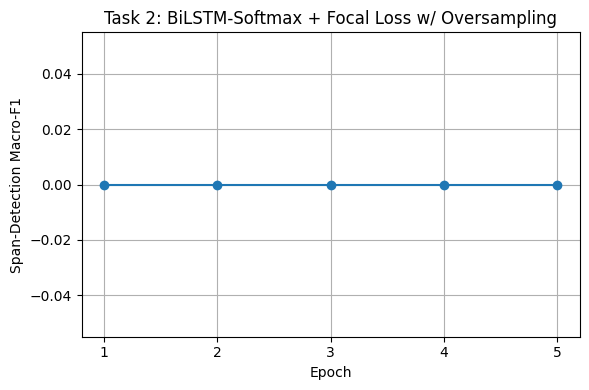

In [ ]:
# Some plotting of oversampling results over epochs
import matplotlib.pyplot as plt

epochs = list(range(1, len(epoch_f1) + 1))
plt.figure(figsize=(6, 4))
plt.plot(epochs, epoch_f1, marker='o')
plt.title('Task 2: BiLSTM-Softmax + Focal Loss w/ Oversampling')
plt.xlabel('Epoch')
plt.ylabel('Span-Detection Macro-F1')
plt.xticks(epochs)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Initial second approach with BERT model
from transformers import BertForTokenClassification, Trainer, TrainingArguments

# Load model
model = BertForTokenClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(tag2id),
    id2label=id2tag,
    label2id=tag2id
)

# Define minimal TrainingArguments
training_args = TrainingArguments(
    output_dir='./bert_task2',
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir='./logs_task2',
    logging_steps=50,
    save_steps=500,
    report_to=['none']
)

# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Fine-tune
trainer.train()

# Manual evaluation
metrics = trainer.evaluate(eval_dataset=val_dataset)
print("Token-classification validation metrics:", metrics)

# Inspect predictions on one example
batch = val_dataset[0]
with torch.no_grad():
    logits = model(
        input_ids=batch['input_ids'].unsqueeze(0),
        attention_mask=batch['attention_mask'].unsqueeze(0)
    ).logits
preds = logits.argmax(-1).squeeze().tolist()
tokens = tokenizer.convert_ids_to_tokens(batch['input_ids'])
print(list(zip(tokens, [id2tag[p] for p in preds])))


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,0.821700
100,0.372400
150,0.345700
200,0.341200
250,0.322800
300,0.347500
350,0.306600
400,0.269100
450,0.293200
500,0.283900


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Token-classification validation metrics: {'eval_loss': 0.2886931598186493, 'eval_f1': 0.011928429423459246, 'eval_report': '                           precision    recall  f1-score   support\n\n appeal_to_fear_prejudice       0.05      0.12      0.07        43\ncausal_oversimplification       0.00      0.00      0.00        31\n                    doubt       0.00      0.00      0.00        38\nexaggeration,minimisation       0.00      0.00      0.00        28\n              flag_waving       0.00      0.00      0.00        39\n          loaded_language       0.00      0.00      0.00        37\n    name_calling,labeling       0.00      0.00      0.00        31\n           not_propaganda       0.01      0.00      0.00       298\n               repetition       0.00      0.00      0.00        32\n\n                micro avg       0.01      0.01      0.01       577\n                macro avg       0.01      0.01      0.01       577\n             weighted avg       0.01      0.01      0.01

In [ ]:
# Task 2 Actual second approach: BERT Token Classification with correct label alignment

import torch
from torch.utils.data import Dataset
from transformers import (
    BertTokenizerFast,
    BertForTokenClassification,
    Trainer,
    TrainingArguments
)
from seqeval.metrics import classification_report, f1_score

# Rebuilding tag2id / id2tag from my BIO strings
all_tags = sorted({tag for seq in bio_train['labels'] for tag in seq})
tag2id   = {tag: i for i, tag in enumerate(all_tags)}
id2tag   = {i: tag for tag, i in tag2id.items()}

# New Dataset that maps special and pad tokens to be -100
class TokenClassDataset(Dataset):
    def __init__(self, bio_dict):
        self.input_ids      = bio_dict['input_ids']
        self.attention_mask = bio_dict['attention_mask']
        raw_labels          = bio_dict['labels']
        self.labels         = []

        for ids, mask, labs in zip(self.input_ids, self.attention_mask, raw_labels):
            aligned = []
            for token_id, m, lab in zip(ids, mask, labs):
                # special tokens and paddding being ignored
                if m == 0 or token_id in (tokenizer.cls_token_id, tokenizer.sep_token_id, tokenizer.pad_token_id):
                    aligned.append(-100)
                else:
                    aligned.append(tag2id[lab])
            self.labels.append(aligned)

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids':      torch.tensor(self.input_ids[idx],      dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_mask[idx], dtype=torch.long),
            'labels':         torch.tensor(self.labels[idx],         dtype=torch.long),
        }

train_dataset = TokenClassDataset(bio_train)
val_dataset   = TokenClassDataset(bio_val)

# Load the token‐classification model
model = BertForTokenClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(tag2id),
    id2label=id2tag,
    label2id=tag2id
)

# Metrics function (seqeval)
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    true_tag_seqs = []
    pred_tag_seqs = []
    for label_ids, pred_ids in zip(p.label_ids, preds):
        true_seq, pred_seq = [], []
        for lid, pid in zip(label_ids, pred_ids):
            if lid == -100:
                continue
            true_seq.append(id2tag[int(lid)])
            pred_seq.append(id2tag[int(pid)])
        true_tag_seqs.append(true_seq)
        pred_tag_seqs.append(pred_seq)
    return {
        'f1': f1_score(true_tag_seqs, pred_tag_seqs),
        'report': classification_report(true_tag_seqs, pred_tag_seqs)
    }

# TrainingArguments
training_args = TrainingArguments(
    output_dir='./bert_task2',
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir='./logs_task2',
    logging_steps=50,
    save_steps=500,
    report_to=['none']
)

# training the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)
trainer.train()

# Final evaluation
metrics = trainer.evaluate(eval_dataset=val_dataset)
print("Token‐classification validation metrics:", metrics)

# Sample predictions (for one example)
batch = val_dataset[0]
with torch.no_grad():
    logits = model(
        input_ids=batch['input_ids'].unsqueeze(0),
        attention_mask=batch['attention_mask'].unsqueeze(0)
    ).logits
preds = logits.argmax(-1).squeeze().tolist()
tokens = tokenizer.convert_ids_to_tokens(batch['input_ids'])
print(list(zip(tokens, [id2tag[p] if lid!=-100 else 'IGN'
                        for p, lid in zip(preds, batch['labels'])])))


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,1.567000
100,1.317300
150,1.359200
200,1.288000
250,1.305900
300,1.332400
350,1.192500
400,1.104600
450,1.107700
500,1.053800


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Token‐classification validation metrics: {'eval_loss': 1.191733717918396, 'eval_f1': 0.009184845005740528, 'eval_report': '                           precision    recall  f1-score   support\n\n appeal_to_fear_prejudice       0.02      0.05      0.03        43\ncausal_oversimplification       0.04      0.06      0.05        31\n                    doubt       0.00      0.00      0.00        38\nexaggeration,minimisation       0.00      0.00      0.00        28\n              flag_waving       0.00      0.00      0.00        39\n          loaded_language       0.00      0.00      0.00        37\n    name_calling,labeling       0.00      0.00      0.00        31\n           not_propaganda       0.00      0.00      0.00       298\n               repetition       0.00      0.00      0.00        32\n\n                micro avg       0.01      0.01      0.01       577\n                macro avg       0.01      0.01      0.01       577\n             weighted avg       0.00      0.01      0.00 

In [ ]:
# Evaluating the validation set
metrics = trainer.evaluate(eval_dataset=val_dataset)
print("Token-classification validation metrics:", metrics)

Token-classification validation metrics: {'eval_loss': 1.191733717918396, 'eval_f1': 0.009184845005740528, 'eval_report': '                           precision    recall  f1-score   support\n\n appeal_to_fear_prejudice       0.02      0.05      0.03        43\ncausal_oversimplification       0.04      0.06      0.05        31\n                    doubt       0.00      0.00      0.00        38\nexaggeration,minimisation       0.00      0.00      0.00        28\n              flag_waving       0.00      0.00      0.00        39\n          loaded_language       0.00      0.00      0.00        37\n    name_calling,labeling       0.00      0.00      0.00        31\n           not_propaganda       0.00      0.00      0.00       298\n               repetition       0.00      0.00      0.00        32\n\n                micro avg       0.01      0.01      0.01       577\n                macro avg       0.01      0.01      0.01       577\n             weighted avg       0.00      0.01      0.00 

In [ ]:
# Metrics report returned
print(metrics['eval_report'])


                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.02      0.05      0.03        43
causal_oversimplification       0.04      0.06      0.05        31
                    doubt       0.00      0.00      0.00        38
exaggeration,minimisation       0.00      0.00      0.00        28
              flag_waving       0.00      0.00      0.00        39
          loaded_language       0.00      0.00      0.00        37
    name_calling,labeling       0.00      0.00      0.00        31
           not_propaganda       0.00      0.00      0.00       298
               repetition       0.00      0.00      0.00        32

                micro avg       0.01      0.01      0.01       577
                macro avg       0.01      0.01      0.01       577
             weighted avg       0.00      0.01      0.00       577



In [ ]:
# method 2/ Final BiLSTM-Softmax with printed results Report
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from seqeval.metrics import classification_report, f1_score

# Build tag2id / id2tag
all_tags = sorted({ t for seq in bio_train['labels'] for t in seq })
tag2id   = {t:i for i,t in enumerate(all_tags)}
id2tag   = {i:t for t,i in tag2id.items()}

# Compute counts & weights
from collections import Counter
tag_counts = Counter(t for seq in bio_train['labels'] for t in seq)
weights = [1.0 / (tag_counts[tag] + 1) for tag in all_tags]  # +1 to avoid div0
weight_tensor = torch.tensor(weights)

#Dataset
class SpanDataset(Dataset):
    def __init__(self, bio):
        self.ids    = torch.tensor(bio['input_ids'],      dtype=torch.long)
        self.mask   = torch.tensor(bio['attention_mask'], dtype=torch.long)
        self.labels = torch.tensor(
            [[tag2id[t] for t in seq] for seq in bio['labels']],
            dtype=torch.long
        )
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, i):
        return {
            'input_ids':      self.ids[i],
            'attention_mask': self.mask[i],
            'labels':         self.labels[i],
            'label_ids':      self.labels[i]
        }

train_ds = SpanDataset(bio_train)
val_ds   = SpanDataset(bio_val)

# BiLSTM + Softmax with weighted loss
class BiLSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, emb_dim=64, hid_dim=128, pad_idx=0, weight=None):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.lstm      = nn.LSTM(emb_dim, hid_dim//2, bidirectional=True, batch_first=True)
        self.hidden2tag = nn.Linear(hid_dim, tagset_size)
        # register weight vector for loss
        self.register_buffer("class_weight", weight)

    def forward(self, input_ids, attention_mask, labels=None):
        x = self.embedding(input_ids)
        out,_ = self.lstm(x)
        logits = self.hidden2tag(out)
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss(
                weight=self.class_weight,
                ignore_index=-100
            )
            return loss_fn(
                logits.view(-1, logits.size(-1)),
                labels.view(-1)
            )
        else:
            return torch.argmax(logits, dim=-1)
# Instantiate & train
vocab_size  = tokenizer.vocab_size
tagset_size = len(tag2id)
model = BiLSTMTagger(
    vocab_size, tagset_size,
    emb_dim=64, hid_dim=128,
    pad_idx=tokenizer.pad_token_id,
    weight=weight_tensor
)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=32)

for epoch in range(3):
    model.train()
    total_loss = 0.0
    for batch in train_loader:
        optim.zero_grad()
        loss = model(
            batch['input_ids'],
            batch['attention_mask'],
            batch['labels']
        )
        loss.backward()
        optim.step()
        total_loss += loss.item()

   #Evaluate
    model.eval()
    true_seqs, pred_seqs = [], []
    with torch.no_grad():
        for batch in val_loader:
            preds = model(batch['input_ids'], batch['attention_mask'])
            for true_lbls, pred_lbls, mask in zip(batch['labels'], preds, batch['attention_mask']):
                t = [id2tag[int(t_)] for t_, m in zip(true_lbls, mask) if m]
                p = [id2tag[int(p_)] for p_, m in zip(pred_lbls, mask) if m]
                true_seqs.append(t); pred_seqs.append(p)

    f1 = f1_score(true_seqs, pred_seqs)
    print(f"Epoch {epoch+1} | Loss {total_loss/len(train_loader):.4f} | Val F1 {f1:.4f}")

print("\nFinal BiLSTM-Softmax Report:")
print(classification_report(true_seqs, pred_seqs))




Epoch 1 | Loss 2.8331 | Val F1 0.0018
Epoch 2 | Loss 2.4988 | Val F1 0.0027
Epoch 3 | Loss 2.2651 | Val F1 0.0034

Final BiLSTM-Softmax Report:
                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.00      0.00      0.00        43
causal_oversimplification       0.00      0.00      0.00        31
                    doubt       0.00      0.05      0.00        38
exaggeration,minimisation       0.00      0.00      0.00        28
              flag_waving       0.00      0.08      0.00        39
          loaded_language       0.00      0.03      0.00        37
    name_calling,labeling       0.00      0.00      0.00        31
           not_propaganda       0.00      0.05      0.01       298
               repetition       0.00      0.09      0.00        32

                micro avg       0.00      0.04      0.00       577
                macro avg       0.00      0.03      0.00       577
             weighted avg       0.00      0.04    